In [1]:
"""
Created by xzy385
Signal Processing flow testing
University of Texas at San Antonio
Fall 2016

"""

'\nCreated by xzy385\nSignal Processing flow testing\nUniversity of Texas at San Antonio\nFall 2016\n\n'

In [2]:
from __future__ import division
from scipy import signal
from sklearn import preprocessing
from sklearn import naive_bayes
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import peakutils
from scipy.stats import threshold
import scipy
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import FastICA
from sklearn.decomposition import TruncatedSVD
%matplotlib inline

In [3]:
def DEAP_process(Live_matrix,Fs):
    Live_matrix = Live_matrix[0:8,:]
    nyq = 0.5*Fs
    low = 4.0/nyq
    high = 45.0/nyq
    b = signal.firwin(61,[4.0, 45.0],pass_zero=False,window='hamming',nyq=64.0)
#    b,a = signal.butter(4, [low, high], btype='bandpass',analog = False)    # 9th order bandstop filtering 50-60 hz
    Mpre = signal.lfilter(b,1.0,Live_matrix, axis=1)
#    np.array([np_convolve(xi, b, mode='valid') for xi in x])

        
    ica = FastICA()
    S_ = ica.fit_transform(Mpre)  # Reconstruct signals
    A_ = ica.mixing_
    A_=A_.T
    
    # Remove baseline of the signals
    x,y = np.shape(A_)
    A = np.zeros((x,y))
    for i in range(0,x):
        base = np.mean(A_,axis=1)
        A[i,:] = A_[i,:]-base[i]
    
    return A

In [4]:
def preprocess(M,Fs): 
    """ Preprocessing of the signal 
    First: Perform a high pass filter to get rid of any dc or signals below 1 Hz
    apply a Bandstop filter for A/C noise between 50-60 Hz
    Normalize the matrix setting all values between -1 and 1 
    """
    # http://scikit-learn.org/stable/modules/preprocessing.html
    nyq = 0.5*Fs
    # use hoffman filter
	# https://sccn.ucsd.edu/svn/software/tags/EEGLAB7_0_0_2beta/functions/popfunc/pop_eegfilt.m
	# pop_eegfilt https://github.com/widmann/firfilt/blob/master/pop_eegfiltnew.m
	# Hamming window filt order +1
    b = signal.firwin(65,[4.0],pass_zero=False,window='hamming',nyq=64.0)
	# b = firws(order, cutoff/nyq, windowarray)
    Mfilt = signal.lfilter(b,1.0,M,axis=1)

    # remove Baseline of signal
    Mfilt = signal.detrend(Mfilt, axis=1)
    
    # Bandstop filter
    bb = signal.firwin(65,[50.0, 60.0],window='hamming',nyq=64.0)
    
#    low = 50.0/nyq
#    high = 64.0/nyq    
    Mpre = signal.lfilter(bb,1.0,Mfilt,axis=1)
   
    # normalized Matrix M
    #sklearn.preprocessing.maxabs_scale
#    mm = np.max(Mpre)
#    mi = np.min(Mpre)
    x,y = np.shape(Mpre)
    M_normalized=np.zeros((x,y))
    for k in range(0,x):
        
        mm = np.max(Mpre[k,:])
        mi = np.min(Mpre[k,:])
        M_normalized[k,:] = (Mpre[k,:]-mi)/(mm-mi) # normalize to zero and 1
        M_normalized[k,:] = (M_normalized[k,:]*2) -1 # change range from -1 to 1 range = 1--1 + min
		#http://stackoverflow.com/questions/10364575/normalization-in-variable-range-x-y-in-matlab
    if x == 9:
        np.delete(M_normalized, (8), axis = 0)
    #M_normalized[8,:] = 0
#    M_normalized = M_normalized[[0,1,2,3,5,6,7],:]  # remove C4 channel
    
    return M_normalized

In [5]:
def Mpsd(M,Fs):
    psdf = []
    psdx = []
#    psdf, psdx = signal.periodogram(M, Fs, axis=1)
	# https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.welch.html#scipy.signal.welch
    # https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.hanning.html#scipy.signal.hanning
	# hanning(M[, sym])	Return a Hann window.
 
    win = signal.get_window('hanning',4*Fs)
    psdf, psdx = signal.welch(M,Fs,window = win,nperseg=4*Fs, noverlap = 2*Fs,axis=1)
    
    return psdf, psdx

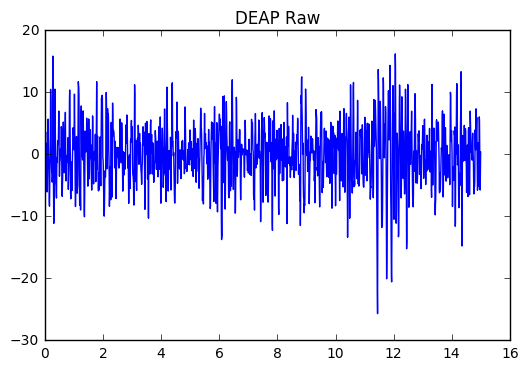

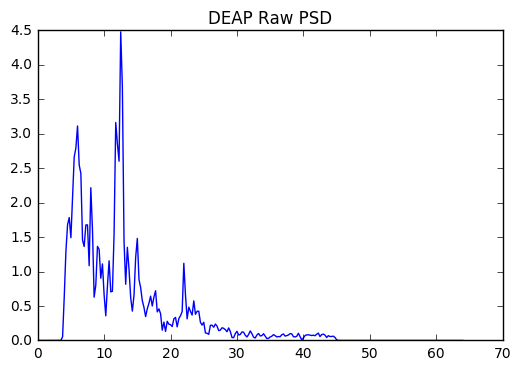

In [6]:
Fs = 128.0	
WS = 15 # window size variable
t= np.arange(0,WS*Fs)*1/Fs
s1_happy = np.load('C:\\Users\\Heath\\Google Drive\\UTSA\\05_Fall 16\\Senior Design\\EEG_Project_Code\\CODENAME_Duthess\\Data\\Training\\happyW{0}.npy'.format(WS))
s1_angry = np.load('C:\\Users\\Heath\\Google Drive\UTSA\\05_Fall 16\\Senior Design\\EEG_Project_Code\\CODENAME_Duthess\\Data\\Training\\angryW{0}.npy'.format(WS))
s1_sad = np.load('C:\\Users\\Heath\\Google Drive\UTSA\\05_Fall 16\\Senior Design\\EEG_Project_Code\\CODENAME_Duthess\\Data\\Training\\normW{0}.npy'.format(WS))

m1 = np.load('C:\\Users\\Heath\\Google Drive\\UTSA\\05_Fall 16\\Senior Design\\EEG_Project_Code\\CODENAME_Duthess\\'+s1_happy[1]+'.npy')
plt.figure()
plt.plot(t,m1[1,:])
plt.title('DEAP Raw')
m3f, m3p = Mpsd(m1,Fs)
plt.figure()
plt.plot(m3f,m3p[1,:])
plt.title('DEAP Raw PSD')
plt.show()

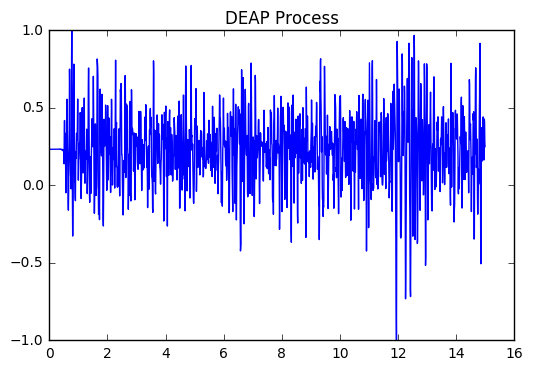

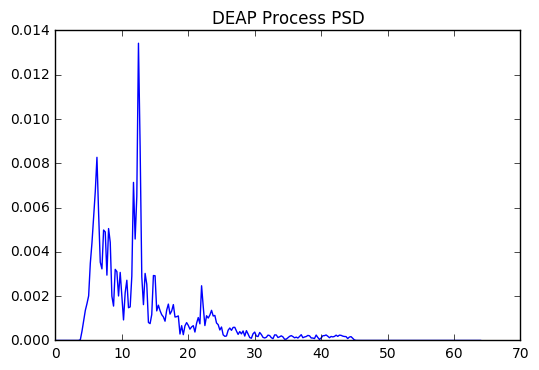

In [7]:
m2 = preprocess(m1,Fs)
plt.figure()
plt.plot(t,m2[1,:])
plt.title('DEAP Process')
m3f2, m3p2 = Mpsd(m2,Fs)
plt.figure()
#plt.semilogy(m3f2,m3p2[1,:])
plt.plot(m3f2,m3p2[1,:])
plt.title('DEAP Process PSD')
plt.show()

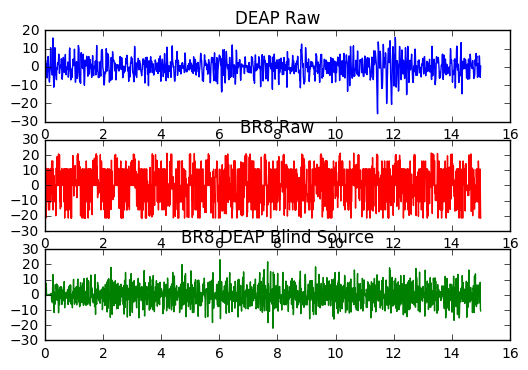

In [8]:
#%%  Raw Brain Rhythm 8 buffer data
raw15 = np.load('C:\\Users\\Heath\\Google Drive\\UTSA\\05_Fall 16\\Senior Design\\EEG_Project_Code\\CODENAME_Duthess\\Data/Training\\Raw\\BR8\\buffer_W15.npy')*1e-8
raw10 = np.load('C:\\Users\\Heath\\Google Drive\\UTSA\\05_Fall 16\\Senior Design\\EEG_Project_Code\\CODENAME_Duthess\\Data/Training\\Raw\\BR8\\buffer_W15.npy')

rd15 = DEAP_process(raw15,Fs)
plt.figure()
plt.subplot(3,1,1)
plt.plot(t,m1[1,:],color='b')
plt.title('DEAP Raw')
plt.subplot(3,1,2)
plt.plot(t,raw15[1,:],color='r')
plt.title('BR8 Raw')
plt.subplot(3,1,3)
plt.plot(t,rd15[1,:],color='g')
plt.title('BR8 DEAP Blind Source')
plt.show()

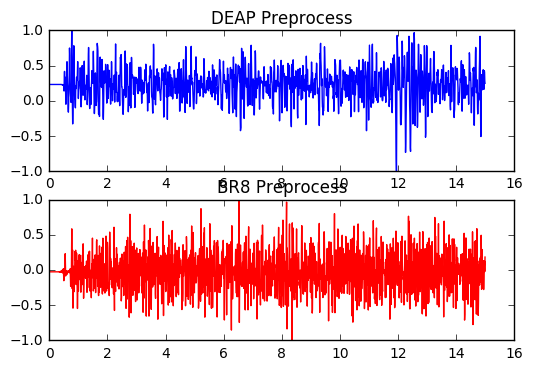

In [9]:
rp15 = preprocess(rd15,Fs)
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,m2[1,:],color='b')
plt.title('DEAP Preprocess')
plt.subplot(2,1,2)
plt.plot(t,rp15[1,:],color='r')
plt.title('BR8 Preprocess')
plt.show()

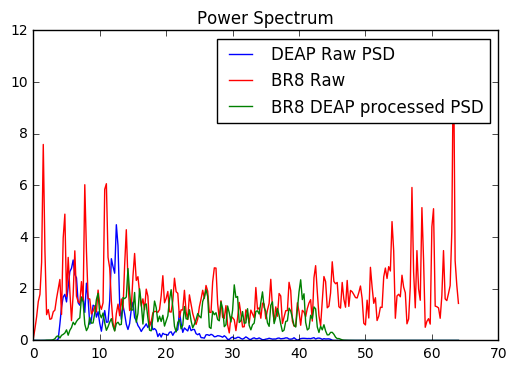

In [10]:
raw15f, raw15p = Mpsd(raw15,Fs)
rd15f, rd15p = Mpsd(rd15,Fs)
rp15f, rp15p = Mpsd(rp15,Fs)

plt.figure()
plt.title('Power Spectrum')
plt.plot(m3f,m3p[1,:],color='b',label='DEAP Raw PSD')
plt.plot(m3f,raw15p[1,:],color='r',label='BR8 Raw')
plt.plot(m3f,rd15p[1,:],color='g',label='BR8 DEAP processed PSD')
plt.legend()
plt.show()

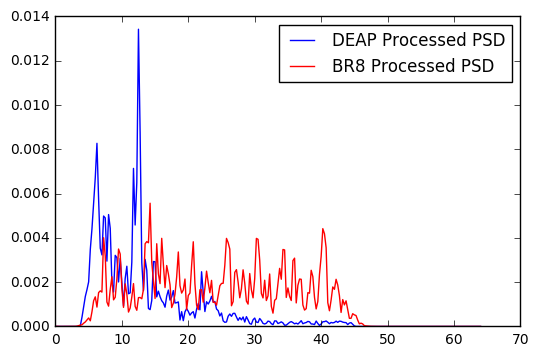

In [11]:
plt.figure()
plt.plot(m3f2,m3p2[1,:],color='b',label='DEAP Processed PSD')
plt.plot(m3f,rp15p[1,:],color='r',label='BR8 Processed PSD')
plt.legend()
plt.show()

In [12]:
""" --------------------------------------------Band Pass ---------------------------------------------"""
def alpha(M, Fs):  
    """This function computes the band pass filter of all 5 frequency components of brain waves """
    # bands delta(1-3), theta(4-7), alpha(8-13), beta(14-30), gamma(31-43)
    nyq = 0.5*Fs
    lowa = 8.0/nyq
    higha = 13.0/nyq
    
    ba = signal.firwin(61,[lowa, higha],pass_zero=False,window='hamming')    
    Malpha = signal.lfilter(ba,1.0,M, axis=1)
    
    lowb = 14.0/nyq
    highb = 30.0/nyq
    
    bb = signal.firwin(61,[lowb, highb],pass_zero=False,window='hamming')	
    Mbeta = signal.lfilter(bb,1.0,M, axis=1)
    
    lowd = 1.0/nyq
    highd = 3.0/nyq
    
    bd = signal.firwin(61,[lowd, highd],pass_zero=False,window='hamming')    
    Mdelta = signal.lfilter(bd,1.0,M, axis=1)
        
    lowg = 31.0/nyq
    highg = 43.0/nyq
    
    bg = signal.firwin(61,[lowg, highg],pass_zero=False,window='hamming') 	
    Mgamma = signal.lfilter(bg,1.0,M, axis=1)
    
    lowt = 4.0/nyq
    hight = 7.0/nyq
    
    bt = signal.firwin(61,[lowt, hight],pass_zero=False,window='hamming')     
    Mtheta = signal.lfilter(bt,1.0,M, axis=1)    
    
    return Malpha, Mbeta, Mdelta, Mgamma, Mtheta

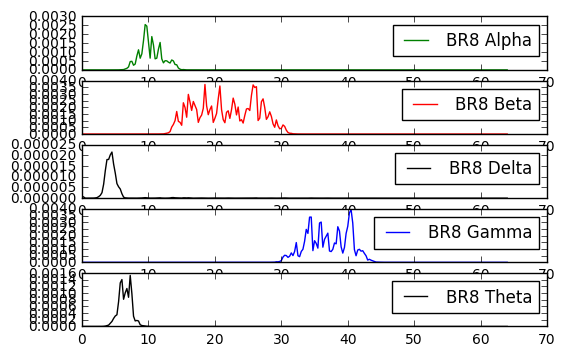

In [13]:
 # bands delta(1-3), theta(4-7), alpha(8-13), beta(14-30), gamma(31-43)
br15a, br15b,br15d,br15g,br15t = alpha(rp15,Fs)
br15f, br15a = Mpsd(br15a,Fs)
br15f, br15b = Mpsd(br15b,Fs)
br15f, br15d = Mpsd(br15d,Fs)
br15f, br15g = Mpsd(br15g,Fs)
br15f, br15t = Mpsd(br15t,Fs)

plt.figure()
plt.title('Power Bands')
plt.subplot(5,1,1)
plt.plot(m3f,br15a[1,:],color='g',label='BR8 Alpha')
plt.legend()
plt.subplot(5,1,2)
plt.plot(m3f,br15b[1,:],color='r',label='BR8 Beta')
plt.legend()
plt.subplot(5,1,3)
plt.plot(m3f,br15d[1,:],color='k',label='BR8 Delta')
plt.legend()
plt.subplot(5,1,4)
plt.plot(m3f,br15g[1,:],color='b',label='BR8 Gamma')
plt.legend()
plt.subplot(5,1,5)
plt.plot(m3f,br15t[1,:],color='k',label='BR8 Theta')
plt.legend()
plt.show()

In [14]:
#%%
def absolute_PSD(band):
    """ This function calculates the total power in a given band, integrating to find the area under the curve.
    band is the PSD array of the filterd alpha, beta, delta, gamma or theta signal. """
    #low freq - lower limit of integrtion
    #high freq - upper limit of integration
    #PSD of band
#    abs_psd = integrate.trapz(band,axis =1)
    abs_psd = np.sum(band,axis=1)
    power = np.sum(abs_psd)
    
    
    return abs_psd, power
#%%
def abs_psd_feature(Live_matrix,Fs):
    """ take the abs_psd of each band, alpha, beta, delta, gamma and theta, and aggregate them into a vector that
    can be used as a feature for the classifier. """
    
    Malph, Mbeta, Mdelta, Mgamma, Mtheta = alpha(Live_matrix,Fs)
    psdfa, alphaa = Mpsd(Malph, Fs)
    psdfb, beta = Mpsd(Mbeta, Fs)
    psdfd, delta = Mpsd(Mdelta, Fs)
    psdfg, gamma = Mpsd(Mgamma, Fs)
    psdft, theta = Mpsd(Mtheta, Fs)
    
    alphaabs, powera = absolute_PSD(alphaa)
    betaabs, powerb = absolute_PSD(beta)
    deltaabs, powerd = absolute_PSD(delta)
    gammaabs, powerg = absolute_PSD(gamma)
    thetaabs, powert = absolute_PSD(theta)
    x,y = np.shape(Live_matrix)
    feature=np.zeros((1,8))
    """Make a 9x5 array, each row is a channel PSD, each column is a frequency band """
    feature = alphaabs.T
    feature = np.append(feature, betaabs)
    feature = np.append(feature, deltaabs)
    feature = np.append(feature, gammaabs)
    feature = np.append(feature, thetaabs)
    feature= np.reshape(feature,(1,x*5))
#    feature = powera
#    feature = np.column_stack((feature, powerb))
#    feature = np.column_stack((feature, powerd))
#    feature = np.column_stack((feature, powerg))
#    feature = np.column_stack((feature, powert))

    return feature

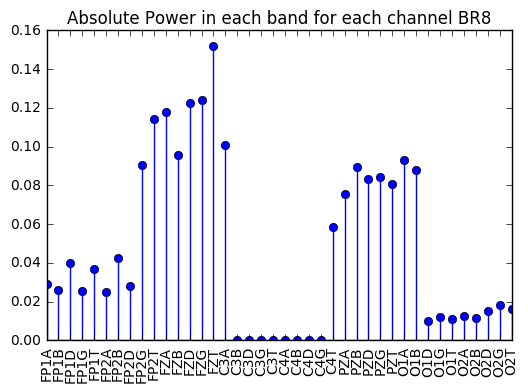

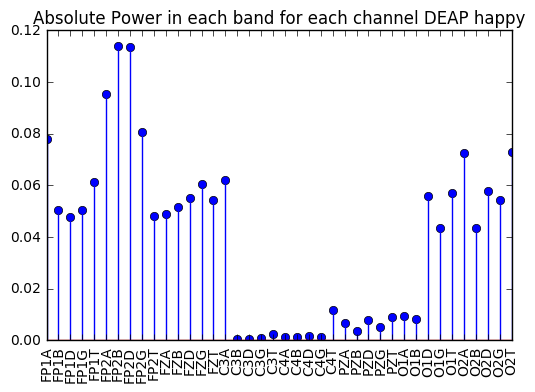

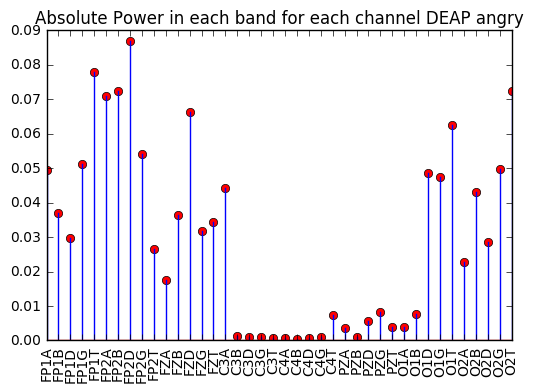

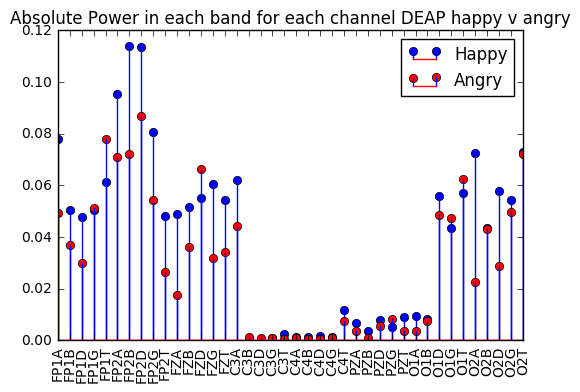

In [15]:
absfeat = abs_psd_feature(rp15,Fs)
#'Fp1', 'Fp2', 'Fz', 'C3', 'C4', 'Pz', 'O1', 'O2', 'STI014'
xtik = ['FP1A','FP1B','FP1D','FP1G','FP1T','FP2A','FP2B','FP2D','FP2G','FP2T','FZA','FZB','FZD','FZG','FZT','C3A','C3B','C3D','C3G','C3T','C4A','C4B','C4D','C4G','C4T','PZA','PZB','PZD','PZG','PZT','O1A','O1B','O1D','O1G','O1T','O2A','O2B','O2D','O2G','O2T']
plt.figure()
plt.title('Absolute Power in each band for each channel BR8')
xval = np.arange(1,np.size(absfeat)+1)
plt.xticks(xval, xtik, rotation=90)
plt.stem(xval,absfeat[0,:])
plt.show()


absfeat2 = abs_psd_feature(m2,Fs)
#'Fp1', 'Fp2', 'Fz', 'C3', 'C4', 'Pz', 'O1', 'O2', 'STI014'
xtik = ['FP1A','FP1B','FP1D','FP1G','FP1T','FP2A','FP2B','FP2D','FP2G','FP2T','FZA','FZB','FZD','FZG','FZT','C3A','C3B','C3D','C3G','C3T','C4A','C4B','C4D','C4G','C4T','PZA','PZB','PZD','PZG','PZT','O1A','O1B','O1D','O1G','O1T','O2A','O2B','O2D','O2G','O2T']
plt.figure()
plt.title('Absolute Power in each band for each channel DEAP happy')
xval = np.arange(1,np.size(absfeat)+1)
plt.xticks(xval, xtik, rotation=90)
plt.stem(xval,absfeat2[0,:])
plt.show()

n5 = np.load('C:/Users/Heath/Google Drive/UTSA/05_Fall 16/Senior Design/EEG_Project_Code/CODENAME_Duthess'+s1_angry[3]+'.npy')
n5 = preprocess(n5,Fs)
absfeat3 = abs_psd_feature(n5,Fs)
#'Fp1', 'Fp2', 'Fz', 'C3', 'C4', 'Pz', 'O1', 'O2', 'STI014'
xtik = ['FP1A','FP1B','FP1D','FP1G','FP1T','FP2A','FP2B','FP2D','FP2G','FP2T','FZA','FZB','FZD','FZG','FZT','C3A','C3B','C3D','C3G','C3T','C4A','C4B','C4D','C4G','C4T','PZA','PZB','PZD','PZG','PZT','O1A','O1B','O1D','O1G','O1T','O2A','O2B','O2D','O2G','O2T']
plt.figure()
plt.title('Absolute Power in each band for each channel DEAP angry')
xval = np.arange(1,np.size(absfeat)+1)
plt.xticks(xval, xtik, rotation=90)
markerline, stemlines, baseline = plt.stem(xval,absfeat3[0,:],color='r')
plt.setp(markerline, 'markerfacecolor', 'r')
plt.show()

plt.figure()
plt.title('Absolute Power in each band for each channel DEAP happy v angry')
xval = np.arange(1,np.size(absfeat)+1)
plt.xticks(xval, xtik, rotation=90)
markerline, stemlines, baseline = plt.stem(xval,absfeat2[0,:],color='b',label='Happy')
plt.setp(markerline, 'markerfacecolor', 'b')
markerline2, stemlines2, baseline2 = plt.stem(xval,absfeat3[0,:],color='r',label='Angry')
plt.setp(markerline2, 'markerfacecolor', 'r')
plt.legend()
plt.show()

In [16]:
def hfd(a, k_max):

    r"""
    Compute Higuchi Fractal Dimension of a time series.
    Vectorised version of the eponymous [PYEEG]_ function.
    .. note::
        **Difference with PyEEG:**
        Results is different from [PYEEG]_ which appears to have implemented an erroneous formulae.
        [HIG88]_ defines the normalisation factor as:
        .. math::
            \frac{N-1}{[\frac{N-m}{k} ]\dot{} k}
        [PYEEG]_ implementation uses:
        .. math::
            \frac{N-1}{[\frac{N-m}{k}]}
        The latter does *not* give the expected fractal dimension of approximately `1.50` for brownian motion (see example bellow).
    :param a: a one dimensional floating-point array representing a time series.
    :type a: :class:`~numpy.ndarray` or :class:`~pyrem.time_series.Signal`
    :param k_max: the maximal value of k
    :type k_max: int
    :return: Higuchi's fractal dimension; a scalar
    :rtype: float
    Example from [HIG88]_. This should produce a result close to `1.50`:
    >>> import numpy as np
    >>> import pyrem as pr
    >>> i = np.arange(2 ** 15) +1001
    >>> z = np.random.normal(size=int(2 ** 15) + 1001)
    >>> y = np.array([np.sum(z[1:j]) for j in i])
    >>> pr.univariate.hfd(y,2**8)
    """

    L = []
    x = []
    N = a.size


    # TODO this could be used to pregenerate k and m idxs ... but memory pblem?
    # km_idxs = np.triu_indices(k_max - 1)
    # km_idxs = k_max - np.flipud(np.column_stack(km_idxs)) -1
    # km_idxs[:,1] -= 1
    #

    for k in xrange(1,k_max):
        Lk = 0
        for m in xrange(0,k):
            #we pregenerate all idxs
            idxs = np.arange(1,int(np.floor((N-m)/k)),dtype=np.int32)

            Lmk = np.sum(np.abs(a[m+idxs*k] - a[m+k*(idxs-1)]))
            Lmk = (Lmk*(N - 1)/(((N - m)/ k)* k)) / k
            Lk += Lmk


        L.append(np.log(Lk/(m+1)))
        x.append([np.log(1.0/ k), 1])

    (p, r1, r2, s)=np.linalg.lstsq(x, L)
    return p[0]

def hfd_valarous(M):
    # higuchi fractal dimension
    #'Fp1', 'Fp2', 'Fz', 'C3', 'C4', 'Pz', 'O1', 'O2', 'STI014'
    x,y = np.shape(M)
    k = 2**3
    if x == 8:
        
        arous = hfd(M[5,:],k) #Ideally FC6 use PZ or C4
        val = hfd(M[4,:],k)-hfd(M[3,:],k) #Ideally AF3-F4 we do C4-FP1
    else: # if C4 is removed from matrix due to faulty sensor
        arous = hfd(M[4,:],k) #Ideally FC6 use PZ or C4
        val = hfd(M[4,:],k)-hfd(M[3,:],k)
    
    #(val-mi)/(mm-mi) # normalize to zero and 1
    #(val*max-min) + min
    minval = -0.15
    maxval = 0.15
    minarous = 1.30
    maxarous = 2.0
    
    pval = (((val-minval)/(maxval-minval))*(8))+1
    parous = (((arous-minarous)/(maxarous-minarous))*(4))+5
    
#    return arous, val
    return parous,pval

In [17]:
m4 = np.load('C:/Users/Heath/Google Drive/UTSA/05_Fall 16/Senior Design/EEG_Project_Code/CODENAME_Duthess'+s1_happy[2]+'.npy')
n4 = np.load('C:/Users/Heath/Google Drive/UTSA/05_Fall 16/Senior Design/EEG_Project_Code/CODENAME_Duthess'+s1_angry[2]+'.npy')
n5 = np.load('C:/Users/Heath/Google Drive/UTSA/05_Fall 16/Senior Design/EEG_Project_Code/CODENAME_Duthess'+s1_angry[3]+'.npy')

arous,val = hfd_valarous(rp15)
print "Arousal = %f , Valence = %f" %(arous,val)
aroush,valh = hfd_valarous(m2)
print "Arousal = %f , Valence = %f" %(aroush,valh)
#n4 = preprocess(n4,Fs)
arousa,vala = hfd_valarous(n4)
print "Arousal = %f , Valence = %f" %(arousa,vala)

Arousal = 8.629410 , Valence = 4.863740
Arousal = 6.447023 , Valence = 4.521451
Arousal = 6.596119 , Valence = 4.409379


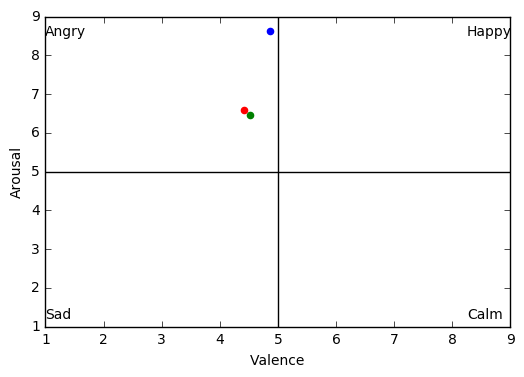

In [18]:
plt.figure()
plt.scatter(val,arous, label = 'Unkown',color='b')
plt.scatter(valh,aroush, label = 'Happy',color='g')
plt.scatter(vala,arousa,label = 'Angry',color='r')
plt.plot([1,9],[5,5],color='k')
plt.plot([5,5],[1,9],color='k')
plt.xlim(1,9)
plt.ylim(1,9)
plt.text(1,8.5,"Angry")
plt.text(8.25,8.5,"Happy")
plt.text(8.25,1.2,"Calm")
plt.text(1,1.2,"Sad")
plt.xlabel("Valence")
plt.ylabel("Arousal")
plt.show()

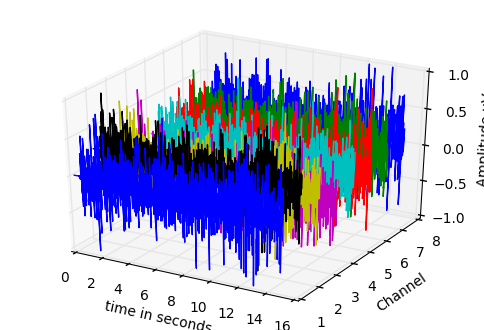

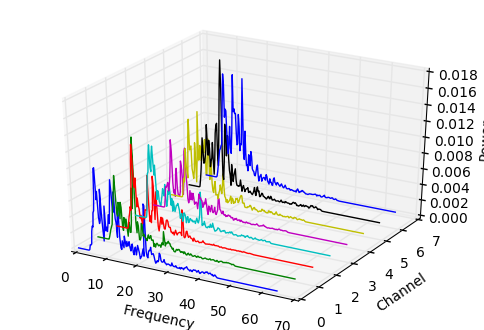

In [19]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
#y=np.array([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0])
y = np.ones((8,np.size(t)))
x = t
for k in range(8,0,-1):
    ax.plot(x[:],y[k-1]*k, m2[k-1,:], label='parametric curve',zdir='z')
    ax.set_ylabel('Channel')
    ax.set_xlabel('time in seconds')
    ax.set_zlabel('Amplitude uV')
plt.show()
    
y2 = np.ones((8,np.size(m3f2)))    
fig = plt.figure()
ax = fig.gca(projection='3d')    
for k in range(0,8):
    ax.plot(m3f2[:],y2[k]*k, m3p2[k,:], label='parametric curve',zdir='z')
    ax.set_ylabel('Channel')
    ax.set_xlabel('Frequency')
    ax.set_zlabel('Power')
plt.show()

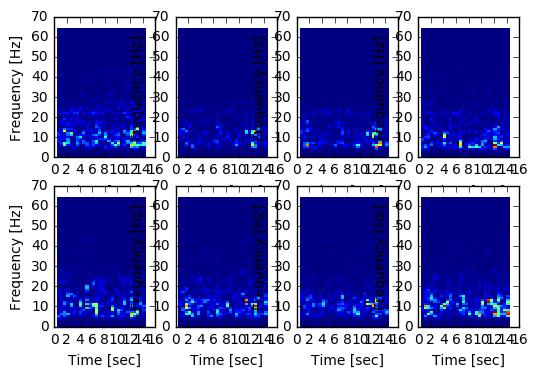

C:\Users\Heath\Anaconda2\lib\site-packages\scipy\signal\spectral.py:772: UserWarning: nperseg = 256, is greater than input length = 65, using nperseg = 65
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))


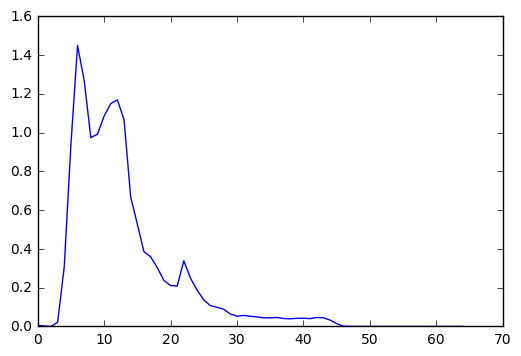

In [20]:
#%%

win = signal.get_window('hanning',int(Fs))
f, t, S = signal.spectrogram(m2,Fs,window=win,nperseg=Fs,noverlap=Fs/2)
x,y,z = np.shape(S)
# channels, frequencies, time

plt.figure()
for k in range(0,x):
    plt.subplot(2,4,k+1)
    plt.pcolormesh(t, f, S[k,:,:])
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
plt.show()

spec_feat = np.sum(np.sum(S,axis=2),axis = 0)

plt.figure()
fr = np.arange(0,65)
plt.plot(fr,spec_feat)

fc,pc = signal.csd(S[:,:,0],S[:,:,z-1],Fs)

In [21]:
#%%
#zijings formulas
# Frequency Variability
# https://github.com/ZijingMao/baselineeegtest/blob/master/BaselineTest/FeatureUtility/freq_var.m
fv1 = np.sum(np.multiply(m3p2,np.multiply(m3f2,m3f2)),axis=1)
fv2 = np.square(np.sum(np.multiply(m3p2,m3f2),axis=1))/np.sum(m3p2,axis=1)
fv3 = np.sum(m3p2,axis=1)

FV = (fv1-fv2)/fv3
FV = np.reshape(FV,(1,8))

# Center of Gravity
"""
CGF=(sum(pxx.*f))/(sum(pxx));
https://en.wikipedia.org/wiki/Spectral_centroid
"""
cog = np.sum(np.multiply(m3p2,m3f2),axis=1)/np.sum(m3p2,axis=1)
cog = np.reshape(cog,(1,8))
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.squeeze.html